# Experimentos y análisis


In [125]:
from matplotlib import pyplot as plt
import pandas as pd
import subprocess
import os

CPU_EXEC = "../build/src/MyProjectCPU"
CL_EXEC = "../build/src/cl/MyProjectCL"
CUDA_EXEC = "../build/src/cuda/MyProjectCUDA"

## Experimento 1
Número de células evaluadas por segundo para varios tamaños de grilla $N \times M$

Variar el tamaño de la grilla con `block/local size` fijos, iteraciones fijas y sin usar `ifs`. `grid/global size` se calculan en el programa.

- Párametros:
    - Tamaño de grilla $N\times M$: Grillas cuadradas de tamaño $2^{8}$ a $2^{24}$ (incrementos de 2). De esta manera se usa de $2*256$ B hasta $2*2^{4}$ MB de memoria (Se multiplica por 2 porque se necesitan tener 2 copias del mundo en memoria)

In [105]:
current_path = os.getcwd()
block = 128
iterations = 1000
n_tests = 10

for i in range(4, 11+1):
    N = 2**i
    M = 2**i
    print("Running for size", N*M)
    # do 10 runs for each size
    for _ in range(n_tests):
        # CPU:                      <world width>   <world height>  <iterations>        <output_file>               <0|1 (debug)>   <0|1 (if)>
        subprocess.run([CPU_EXEC,   str(N),         str(M),         str(iterations),    current_path + "/cpu.csv",  str(0),         str(0)], stdout=subprocess.DEVNULL)
        # CUDA/CL:                  <world width>   <world height>  <block size>    <iterations>        <output file>               <0|1 (debug)>   <0|1 (if)>
        subprocess.run([CL_EXEC,    str(N),         str(M),         str(block),     str(iterations),    current_path + "/cl.csv",   str(0),         str(0)], stdout=subprocess.DEVNULL)
        subprocess.run([CUDA_EXEC,  str(N),         str(M),         str(block),     str(iterations),    current_path + "/cuda.csv", str(0),         str(0)], stdout=subprocess.DEVNULL)

Running for size 256
Running for size 1024
Running for size 4096
Running for size 16384
Running for size 65536
Running for size 262144
Running for size 1048576
Running for size 4194304


### Análisis

In [144]:
# read from csv and add correct columns
cpu = pd.read_csv("cpu.csv", header=None)
cl = pd.read_csv("cl.csv", header=None)
cuda = pd.read_csv("cuda.csv", header=None)

cpu.columns = ["width", "height", "iterations", "data creation time", "execution time", "total time"]
cpu["size"] = cpu["width"] * cpu["height"]
cpu.drop(columns=["width", "height"], inplace=True)

cl.columns = ["size", "block size", "if use", "iterations", "data creation time", "copy to device time", "execution time", "copy to host time", "total time"]
cuda.columns = ["size", "block size", "if use", "iterations", "data creation time", "copy to device time", "execution time", "copy to host time", "total time"]

print("CPU")
print(cpu)
print("CL")
print(cl)
print("CUDA")
print(cuda)

CPU
    iterations  data creation time  execution time  total time     size
0         1000                   7            7572        7579      256
1         1000                   7            6525        6532      256
2         1000                   6            5961        5967      256
3         1000                   6            6289        6295      256
4         1000                   7            6097        6104      256
..         ...                 ...             ...         ...      ...
75        1000               67307       103604823   103672130  4194304
76        1000               68637       103637501   103706138  4194304
77        1000               77869       103530927   103608796  4194304
78        1000               67724       103285892   103353616  4194304
79        1000               66579       103042210   103108789  4194304

[80 rows x 5 columns]
CL
       size  block size  if use  iterations  data creation time  \
0       256         128       0        

#### Tiempo total

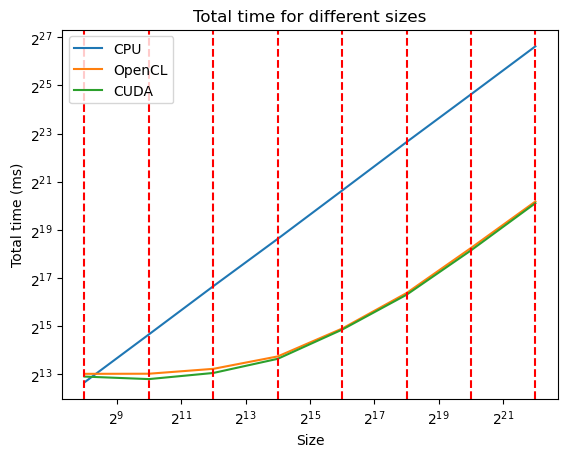

In [145]:
# plot avg total time for each size
cpu_avg = cpu.groupby("size").mean()
cl_avg = cl.groupby("size").mean()
cuda_avg = cuda.groupby("size").mean()

fig, ax = plt.subplots()
ax.plot(cpu_avg.index, cpu_avg["total time"], label="CPU")
ax.plot(cl_avg.index, cl_avg["total time"], label="OpenCL")
ax.plot(cuda_avg.index, cuda_avg["total time"], label="CUDA")
# plot vertical isolines of power of 2
for i in range(8, 22+1, 2):
    ax.axvline(x=2**i, color='r', linestyle='--')

ax.set_yscale('log', base=2)
ax.set_xscale('log', base=2)
ax.set_xlabel("Size")
ax.set_ylabel("Total time (ms)")
ax.legend()
plt.title("Total time for different sizes")
plt.show()
# save figure as svg
fig.savefig("total_time.svg")


#### Tiempo de ejecución

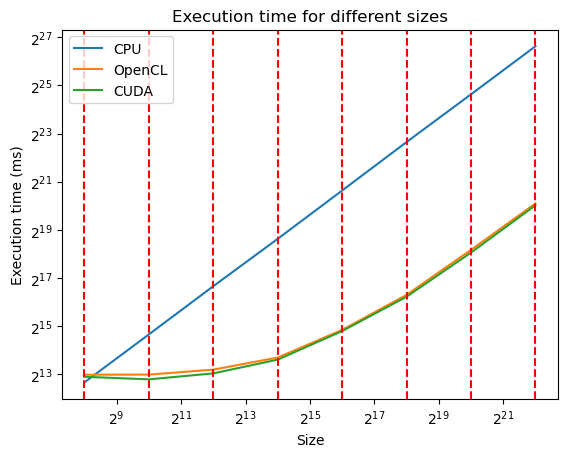

In [146]:
# plot avg execution time for each size
fig, ax = plt.subplots()
ax.plot(cpu_avg.index, cpu_avg["execution time"], label="CPU")
ax.plot(cl_avg.index, cl_avg["execution time"], label="OpenCL")
ax.plot(cuda_avg.index, cuda_avg["execution time"], label="CUDA")
for i in range(8, 22+1, 2):
    ax.axvline(x=2**i, color='r', linestyle='--')

ax.set_yscale('log', base=2)
ax.set_xscale('log', base=2)
ax.set_xlabel("Size")
ax.set_ylabel("Execution time (ms)")
ax.legend()
plt.title("Execution time for different sizes")
plt.show()
fig.savefig("execution_time.svg")

#### Celdas evaluadas por segundo

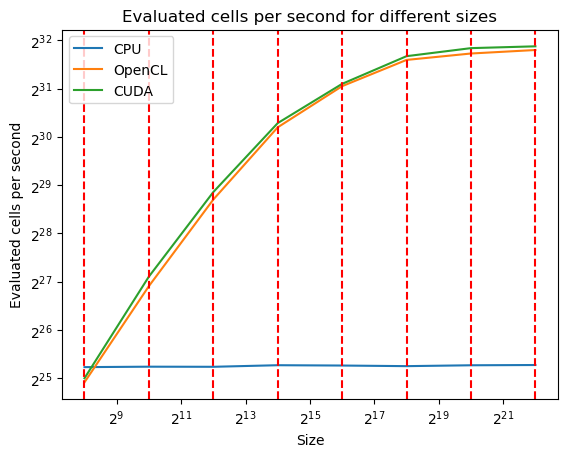

In [153]:
# plot evaluated cells per second for each size

cpu_avg["evaluated cells per second"] = cpu_avg.index*iterations / (cpu_avg["execution time"]/(10**6))
cl_avg["evaluated cells per second"] = cl_avg.index*iterations / (cl_avg["execution time"]/(10**6))
cuda_avg["evaluated cells per second"] = cuda_avg.index*iterations / (cuda_avg["execution time"]/(10**6))

fig, ax = plt.subplots()
ax.plot(cpu_avg.index, cpu_avg["evaluated cells per second"], label="CPU")
ax.plot(cl_avg.index, cl_avg["evaluated cells per second"], label="OpenCL")
ax.plot(cuda_avg.index, cuda_avg["evaluated cells per second"], label="CUDA")
for i in range(8, 22+1, 2):
    ax.axvline(x=2**i, color='r', linestyle='--')

ax.set_yscale('log', base=2)
ax.set_xscale('log', base=2)

ax.set_xlabel("Size")
ax.set_ylabel("Evaluated cells per second")
ax.legend()
plt.title("Evaluated cells per second for different sizes")
plt.show()
fig.savefig("evaluated_cells_per_second.svg")

#### Speedup

In [130]:
# print speedup on execution time
speedup_cl = cpu_avg["execution time"] / cl_avg["execution time"]
speedup_cuda = cpu_avg["execution time"] / cuda_avg["execution time"]

print("Speedup OpenCL")
print(speedup_cl)
print("Speedup CUDA")
print(speedup_cuda)

Speedup OpenCL
size
256         0.803886
1024        3.182395
4096       11.054919
16384      30.496187
65536      55.334193
262144     81.365659
1048576    88.116211
4194304    92.307229
Name: execution time, dtype: float64
Speedup CUDA
size
256         0.852423
1024        3.649272
4096       12.307986
16384      32.393473
65536      57.197897
262144     85.865026
1048576    95.187724
4194304    97.329310
Name: execution time, dtype: float64


#### Distribución de tiempos

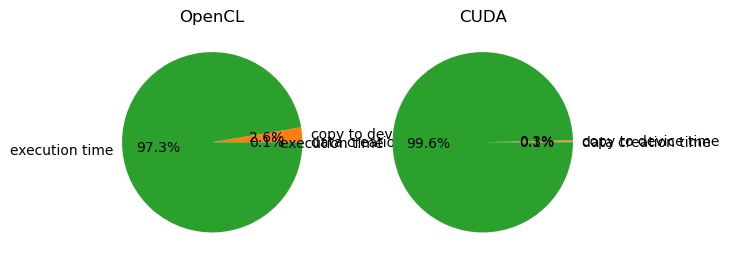

In [131]:
cl_avg["data creation time"] /= cl_avg.index
cl_avg["copy to device time"] /= cl_avg.index
cl_avg["execution time"] /= cl_avg.index
cl_avg["copy to host time"] /= cl_avg.index

cuda_avg["data creation time"] /= cuda_avg.index
cuda_avg["copy to device time"] /= cuda_avg.index
cuda_avg["execution time"] /= cuda_avg.index
cuda_avg["copy to host time"] /= cuda_avg.index

# plot a two pie chart of the average time spent on each step for OpenCL and CUDA
fig, ax = plt.subplots(1, 2)
ax[0].pie(cl_avg.iloc[0][3:6], labels=cl_avg.columns[3:6], autopct='%1.1f%%')
ax[0].set_title("OpenCL")
ax[1].pie(cuda_avg.iloc[0][3:6], labels=cuda_avg.columns[3:6], autopct='%1.1f%%')
ax[1].set_title("CUDA")
plt.show()
fig.savefig("time_spent.svg")

### Conclusión

## Experimento 2
Número de células evaluadas por segundo utilizando ifs (condicionales) para preguntar por la vecindad.  

Utilizar `ifs`, dejar fijo el tamaño de `block/local size` con tamaño de grilla variable, iteraciones fijas y sin usar `grid/global size` se calculan en el programa.

- Párametros:
    - Comparar la activación de los ifs:  
        - Activado (1)  
        - Desactivado (0)
    - Tamaño de grilla $N\times M$: Grillas cuadradas de tamaño $2^{8}$ a $2^{24}$ (incrementos de 2). De esta manera se usa de $2*256$ B hasta $2*2^{4}$ MB de memoria (Se multiplica por 2 porque se necesitan tener 2 copias del mundo en memoria)

In [116]:
current_path = os.getcwd()

for i in range(4, 12+1):
    N = 2**i
    M = 2**i
    print("Running for size", N*M)
    # do 10 runs for each size
    for _ in range(n_tests):
        # CPU:                      <world width>   <world height>  <iterations>        <output_file>               <0|1 (debug)>   <0|1 (if)>
        subprocess.run([CPU_EXEC,   str(N),         str(M),         str(iterations),    current_path + "/cpu_if.csv",  str(0),         str(1)], stdout=subprocess.DEVNULL)
        # CUDA/CL:                  <world width>   <world height>  <block size>    <iterations>        <output file>               <0|1 (debug)>   <0|1 (if)>
        subprocess.run([CL_EXEC,    str(N),         str(M),         str(block),     str(iterations),    current_path + "/cl_if.csv",   str(0),         str(1)], stdout=subprocess.DEVNULL)
        subprocess.run([CUDA_EXEC,  str(N),         str(M),         str(block),     str(iterations),    current_path + "/cuda_if.csv", str(0),         str(1)], stdout=subprocess.DEVNULL)

Running for size 256
Running for size 1024
Running for size 4096
Running for size 16384
Running for size 65536
Running for size 262144
Running for size 1048576
Running for size 4194304


In [132]:
# read from csv and add correct columns
cpu_if = pd.read_csv("cpu_if.csv", header=None)
cl_if = pd.read_csv("cl_if.csv", header=None)
cuda_if = pd.read_csv("cuda_if.csv", header=None)

cpu_if.columns = ["width", "height", "iterations", "data creation time", "execution time", "total time"]
cpu_if["size"] = cpu_if["width"] * cpu_if["height"]
cpu_if.drop(columns=["width", "height"], inplace=True)

cl_if.columns = ["size", "block size", "if use", "iterations", "data creation time", "copy to device time", "execution time", "copy to host time", "total time"]
cuda_if.columns = ["size", "block size", "if use", "iterations", "data creation time", "copy to device time", "execution time", "copy to host time", "total time"]

print("CPU")
print(cpu_if)
print("CL")
print(cl_if)
print("CUDA")
print(cuda_if)

CPU
    iterations  data creation time  execution time  total time     size
0         1000                   8           13025       13033      256
1         1000                   8           11805       11813      256
2         1000                   6           11209       11215      256
3         1000                   6           10979       10985      256
4         1000                   6           11341       11347      256
..         ...                 ...             ...         ...      ...
75        1000               68629       187260853   187329482  4194304
76        1000               67615       187400833   187468448  4194304
77        1000               66045       187232279   187298324  4194304
78        1000               67949       187405630   187473579  4194304
79        1000               69749       185541248   185610997  4194304

[80 rows x 5 columns]
CL
       size  block size  if use  iterations  data creation time  \
0       256         128       1        

#### Tiempo de ejecución

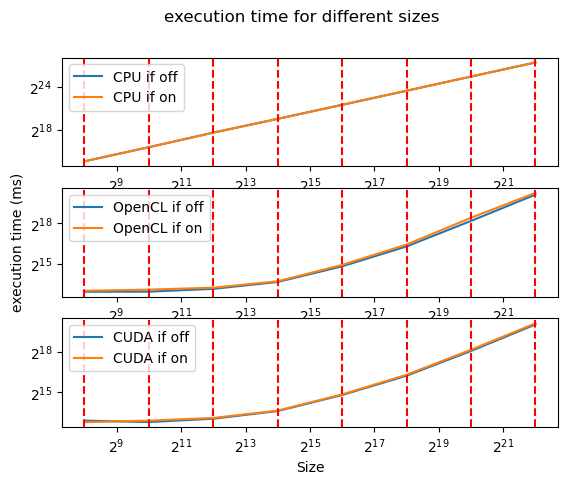

In [163]:
#Ploteamos
# Calculate average execution time by size
cpu_if_avg = cpu_if.groupby("size").mean()
cl_if_avg = cl_if.groupby("size").mean()
cuda_if_avg = cuda_if.groupby("size").mean()

# Plotting
fig, ax = plt.subplots(3)

# Plot each dataset
ax[0].plot(cpu_avg.index, cpu_if_avg["execution time"], label="CPU if off")
ax[0].plot(cpu_if_avg.index, cpu_if_avg["execution time"], label="CPU if on")

ax[1].plot(cl_avg.index, cl_avg["execution time"], label="OpenCL if off")
ax[1].plot(cl_if_avg.index, cl_if_avg["execution time"], label="OpenCL if on")

ax[2].plot(cuda_avg.index, cuda_avg["execution time"], label="CUDA if off")
ax[2].plot(cuda_if_avg.index, cuda_if_avg["execution time"], label="CUDA if on")


# Plot vertical isolines of power of 2
for i in range(8, 22+1, 2):
#     ax.axvline(x=2**i, color='r', linestyle='--')
    [a.axvline(x=2**i, color='r', linestyle='--') for a in ax]

# Set log scales
# ax.set_yscale('log', base=2)
[a.set_yscale('log', base=2) for a in ax]
# ax.set_xscale('log', base=2)
[a.set_xscale('log', base=2) for a in ax]

# Add labels, title, and legend
# ax.set_xlabel("Size")
ax[-1].set_xlabel("Size")
# ax.set_ylabel("execution time (ms)")
ax[1].set_ylabel("execution time (ms)")
# ax.legend()
[a.legend() for a in ax]
# plt.title("execution time for different sizes")
plt.suptitle("execution time for different sizes")

# Show plot
plt.show()
# Save figure as svg
fig.savefig("execution_time_if.svg")

#### Celdas evaluadas por segundo

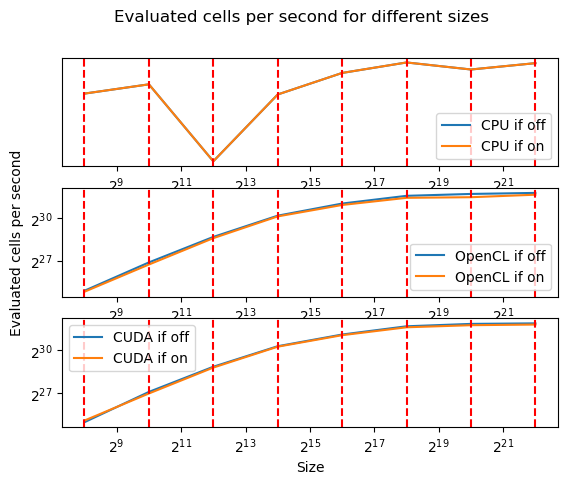

In [164]:
# plot evaluated cells per second for each size

cpu_if_avg["evaluated cells per second"] = cpu_if_avg.index*iterations / (cpu_if_avg["execution time"]/(10**6))
cl_if_avg["evaluated cells per second"] = cl_if_avg.index*iterations / (cl_if_avg["execution time"]/(10**6))
cuda_if_avg["evaluated cells per second"] = cuda_if_avg.index*iterations / (cuda_if_avg["execution time"]/(10**6))

# Plotting
fig, ax = plt.subplots(3)

# Plot each dataset
ax[0].plot(cpu_avg.index, cpu_if_avg["evaluated cells per second"], label="CPU if off")
ax[0].plot(cpu_if_avg.index, cpu_if_avg["evaluated cells per second"], label="CPU if on")

ax[1].plot(cl_avg.index, cl_avg["evaluated cells per second"], label="OpenCL if off")
ax[1].plot(cl_if_avg.index, cl_if_avg["evaluated cells per second"], label="OpenCL if on")

ax[2].plot(cuda_avg.index, cuda_avg["evaluated cells per second"], label="CUDA if off")
ax[2].plot(cuda_if_avg.index, cuda_if_avg["evaluated cells per second"], label="CUDA if on")


# Plot vertical isolines of power of 2
for i in range(8, 22+1, 2):
#     ax.axvline(x=2**i, color='r', linestyle='--')
    [a.axvline(x=2**i, color='r', linestyle='--') for a in ax]

# Set log scales
# ax.set_yscale('log', base=2)
[a.set_yscale('log', base=2) for a in ax]
# ax.set_xscale('log', base=2)
[a.set_xscale('log', base=2) for a in ax]

ax[-1].set_xlabel("Size")
ax[1].set_ylabel("Evaluated cells per second")
# ax.legend()
[a.legend() for a in ax]
plt.suptitle("Evaluated cells per second for different sizes")
plt.show()
fig.savefig("evaluated_cells_per_second_if.svg")

## Experimento 3
Número de células evaluadas por segundo para varios tamaños de bloque

Variar el tamaño de `block/local size` con tamaño de grilla fijo $2^{20}$, iteraciones fijas y sin usar `ifs`. `grid/global size` se calculan en el programa.

- Párametros:
    - Tamaño de bloque:
    
        - Primero usando 6 múltiplos de 32:     32, 64, 128, 256, 512, 1024
    
        - Luego usando 6 no múltiplos de 32:  24, 48, 96, 192, 384, 768

In [24]:
current_path = os.getcwd()
N = 2**10
M = 2**10

for i in range(0, 6):
    block = 2**i * 32
    print("Running for block size", block)
    # do 10 runs for each size
    for _ in range(n_tests):
        # CUDA/CL:                  <world width>   <world height>  <block size>    <iterations>        <output file>               <0|1 (debug)>   <0|1 (if)>
        subprocess.run([CL_EXEC,    str(N),         str(M),         str(block),     str(iterations),    current_path + "/cl_block.csv",   str(0),         str(0)], stdout=subprocess.DEVNULL)
        subprocess.run([CUDA_EXEC,  str(N),         str(M),         str(block),     str(iterations),    current_path + "/cuda_block.csv", str(0),         str(0)], stdout=subprocess.DEVNULL)

for i in range(0, 6):
    block = 2**i * 24
    print("Running for block size", block)
    # do 10 runs for each size
    for _ in range(n_tests):
        # CUDA/CL:                  <world width>   <world height>  <block size>    <iterations>        <output file>               <0|1 (debug)>   <0|1 (if)>
        subprocess.run([CL_EXEC,    str(N),         str(M),         str(block),     str(iterations),    current_path + "/cl_block.csv",   str(0),         str(0)], stdout=subprocess.DEVNULL)
        subprocess.run([CUDA_EXEC,  str(N),         str(M),         str(block),     str(iterations),    current_path + "/cuda_block.csv", str(0),         str(0)], stdout=subprocess.DEVNULL)



Running for block size 32
Running for block size 64
Running for block size 128
Running for block size 256
Running for block size 512
Running for block size 1024
Running for block size 24
Running for block size 48
Running for block size 96
Running for block size 192
Running for block size 384
Running for block size 768


In [165]:
# read from csv and add correct columns
cl_block = pd.read_csv("cl_block.csv", header=None)
cuda_block = pd.read_csv("cuda_block.csv", header=None)

cl_block.columns = ["size", "block size", "if use", "iterations", "data creation time", "copy to device time", "execution time", "copy to host time", "total time"]
cuda_block.columns = ["size", "block size", "if use", "iterations", "data creation time", "copy to device time", "execution time", "copy to host time", "total time"]

print("CL_block")
print(cl_block)
print("CUDA_block")
print(cuda_block)

CL_block
        size  block size  if use  iterations  data creation time  \
0    1048576          32       0         100               16985   
1    1048576          32       0         100               17094   
2    1048576          32       0         100               16214   
3    1048576          32       0         100               16870   
4    1048576          32       0         100               16950   
..       ...         ...     ...         ...                 ...   
115  1048576         768       0         100               16670   
116  1048576         768       0         100               17210   
117  1048576         768       0         100               17121   
118  1048576         768       0         100               16794   
119  1048576         768       0         100               19120   

     copy to device time  execution time  copy to host time  total time  
0                    790           42579                  0       60354  
1                   1004  

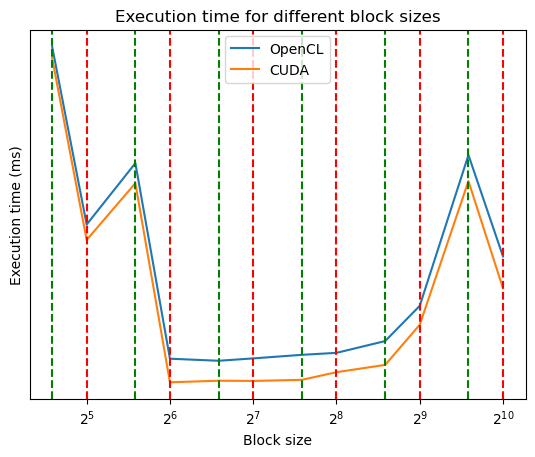

In [166]:
# plot avg total time for each block size
cl_block_avg = cl_block.groupby("block size").mean()
cuda_block_avg = cuda_block.groupby("block size").mean()

# plot avg execution time for each block size
fig, ax = plt.subplots()
ax.plot(cl_block_avg.index, cl_block_avg["execution time"], label="OpenCL")
ax.plot(cuda_block_avg.index, cuda_block_avg["execution time"], label="CUDA")

# plot vertical isolines of power of 2 multiples of 32 and 24
for i in range(0, 6):
    ax.axvline(x=2**i * 32, color='r', linestyle='--')
    ax.axvline(x=2**i * 24, color='g', linestyle='--')

ax.set_yscale('log', base=2)
ax.set_xscale('log', base=2)
ax.set_xlabel("Block size")
ax.set_ylabel("Execution time (ms)")
ax.legend()
plt.title("Execution time for different block sizes")
plt.show()
# save figure as svg
fig.savefig("execution_time_block.svg")

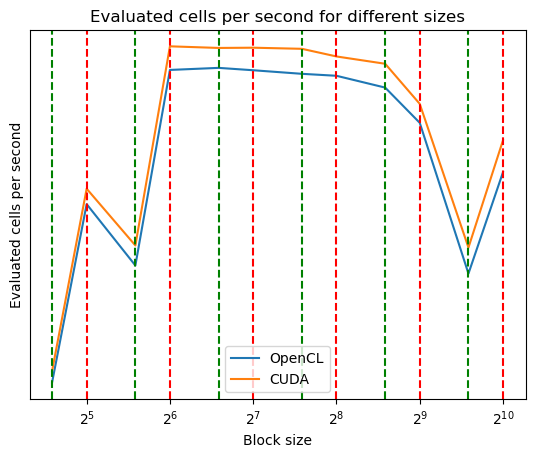

In [168]:
# plot evaluated cells per second for each block size

cl_block_avg["evaluated cells per second"] = cl_block_avg["size"]*iterations / (cl_block_avg["execution time"]/(10**6))
cuda_block_avg["evaluated cells per second"] = cuda_block_avg["size"]*iterations / (cuda_block_avg["execution time"]/(10**6))

fig, ax = plt.subplots()
ax.plot(cl_block_avg.index, cl_block_avg["evaluated cells per second"], label="OpenCL")
ax.plot(cuda_block_avg.index, cuda_block_avg["evaluated cells per second"], label="CUDA")

# plot vertical isolines of power of 2 multiples of 32 and 24
for i in range(0, 6):
    ax.axvline(x=2**i * 32, color='r', linestyle='--')
    ax.axvline(x=2**i * 24, color='g', linestyle='--')

ax.set_yscale('log', base=2)
ax.set_xscale('log', base=2)
ax.set_xlabel("Block size")
ax.set_ylabel("Evaluated cells per second")
ax.legend()
plt.title("Evaluated cells per second for different sizes")
plt.show()
fig.savefig("evaluated_cells_per_second_block.svg")